# Read and analyze case 6126 E08

**BMED320: Methods in biomedical research (IMC-ML)**<br>
_Arvid Lundervold, 20200928_

See: https://github.com/arvidl/BMED320-imaging-mass-cytometry-ml/blob/master/notebooks/imc-case-damond-2019/README.md

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from sklearn.cluster import KMeans

In [2]:
fn_tiff = './data/E08_a0_full.tiff'
fn_csv = './data/E08_a0_full.csv'
fn_panel = './data/table1_IMC_panel_37x4.csv'

In [3]:
im = io.imread(fn_tiff)
print(im.shape)

(37, 530, 567)


In [4]:
n_chn = im.shape[0]
n_chn

37

In [5]:
df = pd.read_csv(fn_csv, usecols=[0], names=['chn'], header=None)
df.shape

(37, 1)

In [6]:
df.head()

,chn
0,In113
1,In115
2,Pr141
3,Nd142
4,Nd143


In [7]:
df.tail()

,chn
32,Yb174
33,Lu175
34,Yb176
35,Ir191
36,Ir193


In [8]:
df.chn.iloc[0]

'In113'

In [9]:
df_p = pd.read_csv(fn_panel)
print(df_p.shape)
df_p

(37, 4)


,Short Name,Antigen,Main Target Cells,Metal Tag
0,INS,Insulin,β,141Pr
1,PIN,Proinsulin,β,154Sm
2,GCG,Glucagon,α,156Gd
3,SST,Somatostatin,δ,159Tb
4,PPY,Pancreatic polypeptide,γ,153Eu
5,NKX6-1,Homeobox protein Nkx-6.1,β,169Tm
6,PDX1,Pancreatic and duodenal homeobox 1,β δ ductal,158Gd
7,IAPP,Amylin,β,167Er
8,PCSK2,Proprotein convertase 2,α,144Nd
9,SYP,Synaptophysin,Endocrine,160Gd


### Plot all channels (except for the last) as a 6 x 6 grid

With histogram equalization for better visualization
https://stackoverflow.com/questions/28518684/histogram-equalization-of-grayscale-images-with-numpy

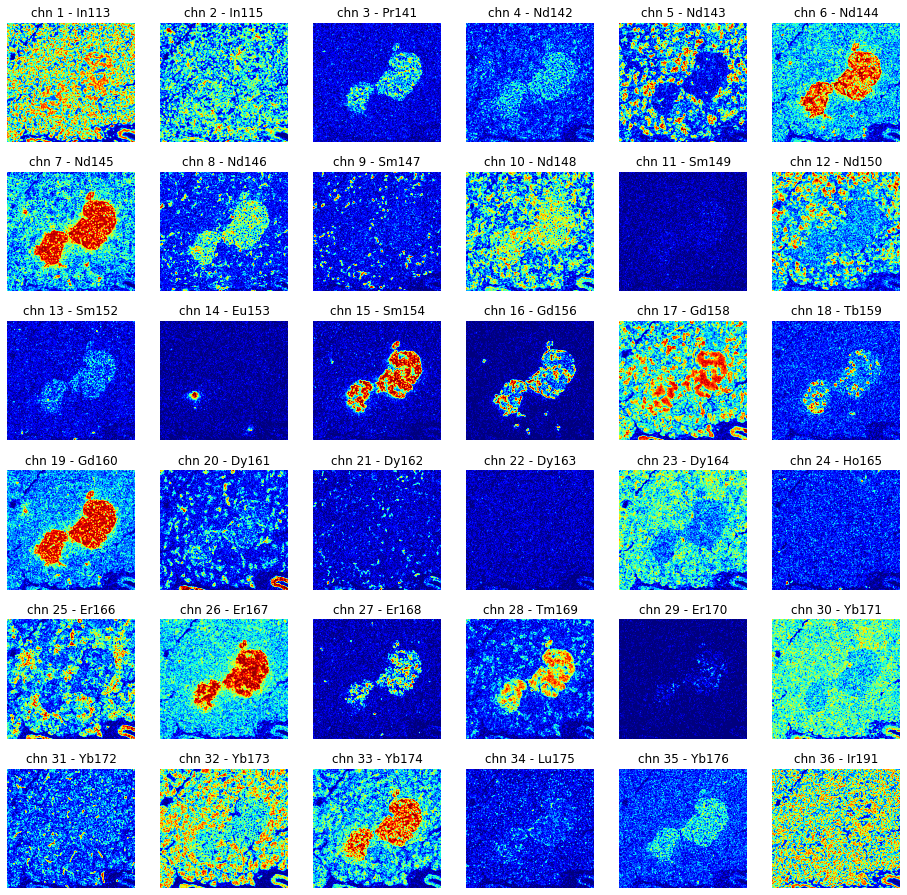

In [10]:
fig, axes = plt.subplots(6, 6, figsize=(16, 16), sharex=False, sharey=False)
ax = axes.ravel()
for i, item in enumerate(range(n_chn-1)):
    chn = np.squeeze(im[i,:,:])
    chn_eq = np.sort(chn.ravel()).searchsorted(chn)
    ax[i].imshow(chn_eq, cmap='jet' )   # cmap='jet', 'gray'
    ax[i].set_title('chn %d - %s' % ((i+1), df.chn.iloc[i]))
    ax[i].axis('off')
plt.show()

## Analyses (incl. K-means clustering)

In [11]:
# Min and macx and number of voxels in the 2D IMC multichannel image
print('Min:', im.flatten().min())
print('Max:', im.flatten().max())
print('Number of voxels:', im.flatten().size)

Min: 0.0
Max: 1473.511
Number of voxels: 11118870


In [12]:
# Generally, we could use a tissue ROI mask for the slide. 
# We let this ROI be the whole first channel in the slide stack + 1, i.e.
im_msk = im[0,:,:]+1
print(im_msk.flatten().min())
print(im_msk.flatten().max())
im_msk.shape

1.0
378.168


(530, 567)

**Find all pixel locations in the ROI for extracting a dataset X and corresponding pixel locations to a Pandas data frame (dfROI)**

In [13]:
# Find voxel locations (ind_roi) corresponding to tissue ROI (value >=1 inside ROI, 0 else) 
ind_roi = np.where(im_msk > 0) 
X = np.transpose(np.asarray(im[:,ind_roi[0],ind_roi[1]])) # The pixel channel signatures within the ROI
print(X.shape)

(300510, 37)


In [14]:
# Check feature vectors (CyTOF pixel signatures) for the three first pixels
dfROI = pd.DataFrame(X)
dfROI.head(3)

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,1.066000,0.000,0.0,0.000,12.395,2.376,1.0,0.000,0.0,4.537,...,0.000,0.0,4.739,2.0,62.405998,6.346,0.0,1.0,2.414000,0.000000
1,11.754000,3.143,0.0,1.000,8.871,5.189,0.0,2.414,0.0,6.969,...,2.926,0.0,2.002,0.0,13.208000,5.364,0.0,0.0,4.589000,18.249001
2,18.483999,1.332,0.0,1.275,3.000,3.032,0.0,0.000,0.0,4.158,...,2.928,0.0,6.211,0.0,1.000000,1.000,0.0,0.0,52.974998,66.415001


In [15]:
# The three last pixels signatures in the enumeration
dfROI.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
300507,29.274000,1.853,1.0,0.0,0.000,1.751,2.413,1.037,0.0,0.000,...,0.0,0.0,2.0,0.0,10.933,3.000,0.0,1.0,30.969999,59.962002
300508,23.422001,0.000,0.0,0.0,1.029,1.344,0.000,0.000,0.0,3.779,...,0.0,0.0,0.0,0.0,9.376,0.000,0.0,0.0,20.679001,35.198002
300509,16.829000,4.459,0.0,0.0,0.000,3.032,0.000,0.000,0.0,0.000,...,0.0,0.0,1.0,0.0,11.806,2.758,0.0,1.0,12.137000,27.128000


**Insert pixel locations in the ROI**

In [16]:
dfROI.insert(loc = len(dfROI.columns),
           column = 'row',
           value = ind_roi[0])  # Row of pixel location
dfROI.insert(loc = len(dfROI.columns),
           column = 'col',
           value = ind_roi[1])  # Col of pixel location

In [17]:
dfROI.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,row,col
0,1.066000,0.000,0.0,0.000,12.395,2.376,1.000,0.000,0.0,4.537,...,4.739,2.000,62.405998,6.346,0.000,1.0,2.414000,0.000000,0,0
1,11.754000,3.143,0.0,1.000,8.871,5.189,0.000,2.414,0.0,6.969,...,2.002,0.000,13.208000,5.364,0.000,0.0,4.589000,18.249001,0,1
2,18.483999,1.332,0.0,1.275,3.000,3.032,0.000,0.000,0.0,4.158,...,6.211,0.000,1.000000,1.000,0.000,0.0,52.974998,66.415001,0,2
3,15.564000,3.129,0.0,0.000,1.000,2.126,1.912,0.000,1.0,0.000,...,0.000,0.000,0.000000,0.000,1.146,0.0,39.678001,81.518997,0,3
4,19.813000,2.000,0.0,0.000,0.000,3.000,0.000,0.000,0.0,0.000,...,2.637,0.536,0.000000,1.000,0.000,0.0,31.754999,80.593002,0,4


In [18]:
dfROI.tail()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,row,col
300505,14.342000,2.000,0.0,0.0,0.000,2.000,0.000,0.000,0.0,0.000,...,0.0,0.0,1.000,0.000,0.0,0.0,25.278999,54.415001,529,562
300506,30.667000,2.838,0.0,0.0,0.000,1.282,0.000,0.000,0.0,0.000,...,0.0,0.0,6.564,1.000,0.0,0.0,38.176998,88.170998,529,563
300507,29.274000,1.853,1.0,0.0,0.000,1.751,2.413,1.037,0.0,0.000,...,2.0,0.0,10.933,3.000,0.0,1.0,30.969999,59.962002,529,564
300508,23.422001,0.000,0.0,0.0,1.029,1.344,0.000,0.000,0.0,3.779,...,0.0,0.0,9.376,0.000,0.0,0.0,20.679001,35.198002,529,565
300509,16.829000,4.459,0.0,0.0,0.000,3.032,0.000,0.000,0.0,0.000,...,1.0,0.0,11.806,2.758,0.0,1.0,12.137000,27.128000,529,566


### Unsupervised classification of the 2D+CyTOF IMC data using K-means
Let X be the n x p data matrix, n = numper of samples (pixel signatures), p = feature vector dimension (number of channels)

In [19]:
X.shape

(300510, 37)

In [20]:
K = 2  # Number of clusters
kmeans_model = KMeans(n_clusters=K, random_state=42)
kmeans_model

KMeans(n_clusters=2, random_state=42)

**Fit the K-means model to the data (and time it)**

In [21]:
%%time
kmeans_fit = kmeans_model.fit(X)

CPU times: user 26.5 s, sys: 1.21 s, total: 27.7 s
Wall time: 1.97 s


In [22]:
print(kmeans_fit.labels_)
print('First centroid in p-dimensional feature vector space:\n', kmeans_fit.cluster_centers_[0,:])

[0 0 1 ... 1 1 1]
First centroid in p-dimensional feature vector space:
 [4.9882393  0.81635916 0.20622067 0.31430438 1.4202658  2.268766
 4.9389205  0.5518438  0.3580299  1.4273021  0.04868286 1.2400048
 0.16773115 0.16485442 1.9414029  0.4549598  2.8245277  0.3631253
 3.0571373  0.46130607 0.14066543 0.07424536 1.0137717  0.2264101
 1.2538469  5.3668456  0.19528975 0.4550116  0.02799512 1.4243537
 0.5353128  6.1252146  2.1608267  0.14304201 0.34982815 4.0518823
 7.499879  ]


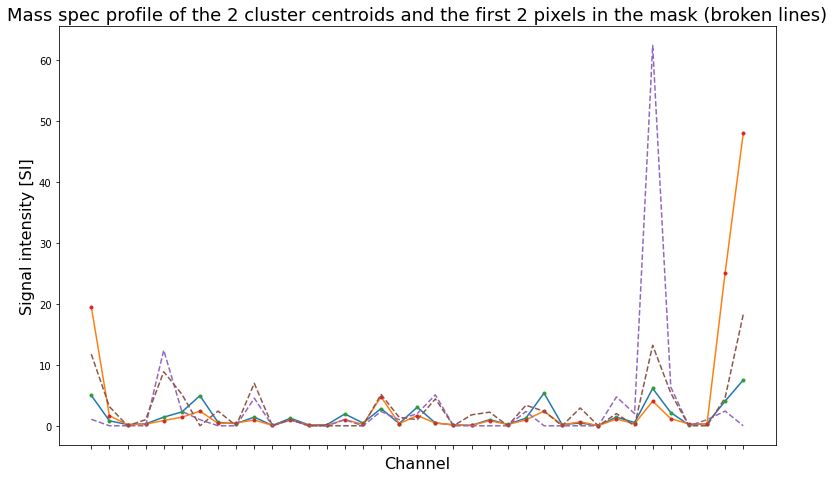

In [23]:
# Plot the cluster centroids as line plots

nv = 2

fig, ax = plt.subplots(1,1)

fig.set_size_inches(12, 7)

plt.plot(kmeans_fit.cluster_centers_.T)
plt.plot(kmeans_fit.cluster_centers_.T, '.')
plt.plot(X[:nv, :].T, '--')
plt.xlabel('Channel', fontsize=16)
ax.set_xticks([x for x in range(X.shape[1])])
ax.set_xticklabels([], rotation='vertical', fontsize=18)
plt.ylabel('Signal intensity [SI]', fontsize=16)
#plt.xlim(0, 3)
plt.title('Mass spec profile of the %d cluster centroids and the first %d pixels in the mask (broken lines)' % (K, nv), fontsize=18)

plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

**Make a k-means segmented image (segmentation restricted to the ROI)**

In [24]:
kmeans_segm2 = 0 * im_msk.copy()
print('Size of segmented image:', kmeans_segm2.shape)
print('min:', kmeans_fit.labels_.min())
print('max:', kmeans_fit.labels_.max())
print('Number of clustered samples within ROI:', len(ind_roi[0]))

Size of segmented image: (530, 567)
min: 0
max: 1
Number of clustered samples within ROI: 300510


**Assign the cluster belonging to each voxel within the ROI**

In [25]:
for v in range(len(ind_roi[0])):
    kmeans_segm2[ind_roi[0][v], ind_roi[1][v]] = kmeans_fit.labels_[v]

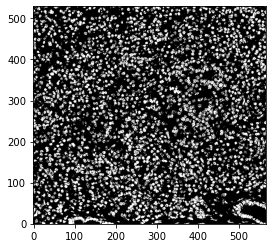

In [26]:
plt.imshow(np.flip(kmeans_segm2[:, :], axis=0), cmap='gray', origin='lower')
plt.show()

**The following function gives the largest connected segmentation which is not backgroud. The shape of input and output is the same which could be 2D or 3D images.**
https://stackoverflow.com/questions/47540926/get-the-largest-connected-component-of-segmentation-image

In [27]:
import numpy as np
from skimage.measure import label

def getLargestCC(segmentation):
    labels = label(segmentation)
    unique, counts = np.unique(labels, return_counts=True)
    list_seg=list(zip(unique, counts))[1:] # the 0 label is by default background so take the rest
    largest=max(list_seg, key=lambda x:x[1])[0]
    labels_max=(labels == largest).astype(int)
    return labels_max

In [28]:
kmeans_segm2_max = getLargestCC(kmeans_segm2)

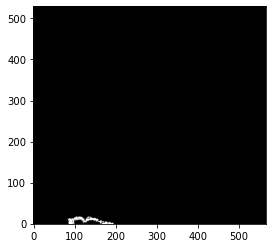

In [29]:
plt.imshow(np.flip(kmeans_segm2_max[:, :], axis=0), cmap='gray', origin='lower')
plt.show()

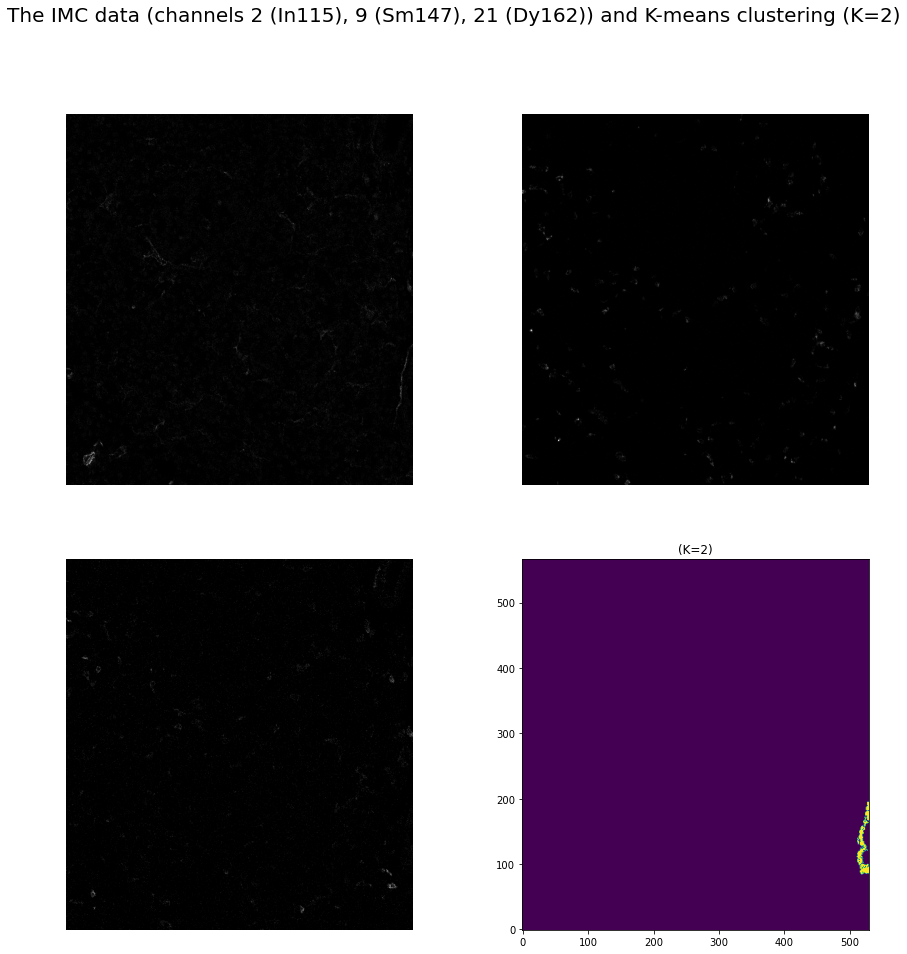

In [30]:
c = [1, 8 ,20]


fig, axes = plt.subplots(2,2, figsize=(15,15))
ax = axes.ravel()
ax[0].imshow(im[c[0], :, :].T, cmap='gray', origin='lower')
ax[0].set(xlabel="")
ax[0].axis('off')
ax[1].imshow(im[c[1], :, :].T, cmap='gray', origin='lower')
ax[1].set(xlabel="")
ax[1].axis('off')
ax[2].imshow(im[c[2], :, :].T, cmap='gray', origin='lower')
ax[2].set(xlabel="")
ax[2].axis('off')
ax[3].imshow(kmeans_segm2_max[:,:].T, cmap='viridis', origin='lower')  #'viridis', 'gray'
ax[3].set_title('(K=%d)' % (K))
plt.suptitle('The IMC data (channels %d (%s), %d (%s), %d (%s)) and K-means clustering (K=%d)' % \
             (c[0]+1, df.chn.iloc[c[0]],
              c[1]+1, df.chn.iloc[c[1]],
              c[2]+1, df.chn.iloc[c[2]], K), fontsize=20) 
#plt.tight_layout
plt.show()

Check: https://github.com/computational-medicine/BMED360-2020/blob/master/perfusion/01-perf-explore.ipynb for more

## EXTRA

**Create a Z-stack with numpy**
https://forum.image.sc/t/create-a-z-stack-with-numpy/28379


I tried creating a simple/random 5D image like so:

```
data_0 = np.random.randint(0, 255, (2, 5, 3, 300, 300), 'uint8')

with tifffile.TiffWriter('path/to/temp.ome.tiff') as tif:
    tif.save(data_0, metadata={'axes':'TZCYX'})
````

**Problem**

When I try opening it with Fiji, a have a 300X300 colored image but the SizeZ is 1 and SizeT is 10.


**A:** you might get what you want by using imagej=True in the TiffWriter constructor:

``` 
with tifffile.TiffWriter('path/to/temp.ome.tiff', imagej=True) as tif:
    tif.save(data_0)

#or directly
tifffile.imwrite('path/to/temp.ome.tiff', data_0, imagej=True)
```

````
imagej : bool
      If True, write an ImageJ hyperstack compatible file.
      This format can handle data types uint8, uint16, or float32 and
      data shapes up to 6 dimensions in TZCYXS order.
      RGB images (S=3 or S=4) must be uint8.
      ImageJ's default byte order is big-endian but this implementation
      uses the system's native byte order by default.
      ImageJ hyperstacks do not support BigTIFF or compression.
      The ImageJ file format is undocumented.
      When using compression, use ImageJ's Bio-Formats import function.
````
